# Padel: estilos de juegos y probabilidad de éxito

## Introducción
El padel es un deporte en pleno crecimiento, el cual se juega 2 vs 2, y cada equipo cuenta con un entrenador sentado en el banquillo, quien puede hablar con los jugadores cada 2 games cuando cambian de lado de cancha. Se juega al mejor de 3 sets, con partidos que pueden durar desde 45 minutos a 3 horas. 
Al ser un deporte en crecimiento, los premios, el dinero específicamente, no son tan importantes como en otros deportes, por lo que para todas las parejas es importante tener buenas actuaciones, cada cierto tiempo al menos, para obtener premios del torneo y para acaparar auspiciantes.

Una forma de maximizar las oportunidades de tener resultados, o cambiar ante los adversos, es con el cambio de pareja. Estos cambios se pueden llevar a cabo varias veces en el año, solo hace falta el acuerdo entre los nuevos integrantes de la pareja.
Luego del análisis del deporte, confirmado con el modelo de machine learning no supervisado, concluimos que los jugadores tienen 3 tipos de estilo de juego: 

•	Definidores: se destacan por tener alta cantidad de puntos totales y remates junto con moderados  a bajos errores no forzados

•	Oportunistas: valores intermedios entre los definidores y los defensivos. Suelen tener pocos errores no forzados. Según el desarrollo del partido pueden atacar o defender mas

•	Defensivos: en este grupo se juntan jugadores que tienen un estilo de juego defensivo, suelen armar el punto para que defina el compañero y tener pocos remates. En el contexto del estudio, también se suman  los jugadores que comenten gran cantidad de errores no forzados, que por su estilo de juego deberían estar en otro grupo


## Objetivos
- Agrupar a los jugadores de padel según sus estadisticas en diferentes grupos mediante aprendizaje no supervisado
- Realizar un modelo de machine learning para obtener las probabilidades de ganar de las distintas parejas 
- Analizar la regla del cambio de compañero varias veces en el año, teniendo en cuenta las probabilidades y los estilos de juego

In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re 
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

import time


In [57]:
# Registra la hora de inicio
start_time = time.time()

#tarda 11.749894142150879 segundos

### Cargar datos y agregar columna puntos netos

Agregamos columna de puntos netos porque las caracteristicas del dataset mas relevantes son los puntos totales y los errores no forzados, por lo que juntamos ambos valores en una caracteristica para evaluar su incidencia en el análisis,

In [58]:
df_data = pd.read_excel("_ml_jug.xlsx")
#print(df_data.dtypes)

#
df_data["pts_netos"]= df_data["pts_ganados"] - df_data["NF_total"]

### Explorar data set y evaluar missing values

In [59]:
df_data.head(3)

,nombre,edad,alt,pos,torneo,set,saque,NF_total,w_total,sm_total,...,pts_ganados,games_jug,circuito,fase,mano,spcsm,bloc,partido,nfr,pts_netos
0,Bela,43,1.80,izq,abu_d,set1,1,2,4,2,...,7,5,WPT,Cuartos,der,NaN,NaN,NaN,NaN,5
1,Sanyo,38,1.75,der,abu_d,set1,1,4,6,4,...,11,5,WPT,Cuartos,der,NaN,NaN,NaN,NaN,7
2,Bela,43,1.80,izq,abu_d,set2,1,4,2,0,...,3,5,WPT,Cuartos,der,NaN,NaN,NaN,NaN,-1


In [60]:
df_data.shape

(1256, 27)

In [61]:
df_data.columns

Index(['nombre', 'edad', 'alt', 'pos', 'torneo', 'set', 'saque', 'NF_total',
       'w_total', 'sm_total', 'nsmtotal', 'prec sm%', 'csm', 'fondo', 'm3',
       'm5', 'm7', 'pts_ganados', 'games_jug', 'circuito', 'fase', 'mano',
       'spcsm', 'bloc', 'partido', 'nfr', 'pts_netos'],
      dtype='object')

In [62]:
df_data =df_data[df_data["circuito"] == "WPT"] 

In [63]:
round(df_data.describe(),2)

,edad,alt,saque,NF_total,w_total,sm_total,nsmtotal,prec sm%,csm,fondo,m3,m5,m7,pts_ganados,games_jug,spcsm,bloc,nfr,pts_netos
count,1120.00,1120.00,1120.0,1120.00,1120.00,1120.00,1120.00,850.00,1120.00,1120.00,1120.00,1120.00,1120.00,1120.00,1120.00,552.00,552.00,192.00,1120.00
mean,26.73,1.81,1.5,2.02,3.49,1.65,0.86,65.21,0.36,0.23,1.09,1.76,3.67,6.52,4.73,0.45,0.17,1.58,4.49
std,5.84,0.05,0.5,1.58,2.44,1.78,1.16,33.73,0.70,0.50,1.24,1.57,2.29,3.40,0.89,0.71,0.48,1.39,3.79
min,18.00,1.67,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,-7.00
25%,23.00,1.76,1.0,1.00,2.00,0.00,0.00,50.00,0.00,0.00,0.00,1.00,2.00,4.00,4.00,0.00,0.00,0.00,2.00
50%,26.00,1.80,1.5,2.00,3.00,1.00,0.00,67.00,0.00,0.00,1.00,1.00,3.00,6.00,5.00,0.00,0.00,1.00,4.00
75%,29.00,1.85,2.0,3.00,5.00,2.00,1.00,100.00,1.00,0.00,2.00,3.00,5.00,9.00,5.00,1.00,0.00,3.00,7.00
max,47.00,1.90,2.0,9.00,13.00,9.00,7.00,100.00,6.00,3.00,9.00,9.00,15.00,17.00,6.00,3.00,3.00,6.00,17.00


#### Missing values

In [64]:
serie_nan =df_data.isna().sum()


l_na =  [col for col in serie_nan if col != 0]

serie_nan[serie_nan.isin(l_na)]

prec sm%    270
spcsm       568
bloc        568
partido     568
nfr         928
dtype: int64

Las caracteristicas van a ser borradas ya que no son necesarias para el trabajo.

## Creacion de nuevo dataframe (df)
### Se va a crear un df dividiendo las caracteristicas por la cantidad de games jugados.
Se eligieron las 3 columnas mas relevantes al analizar partidos, como son los puntos por game (pxg), errores no forzados por game (nfxg), puntos netos (pts_netos) y remates por game (rem). Las 3 primeras tuvieron una alta correlacion con el resultado, y la cantidad de remates ayuda a diferenciar el estilo de juego de los jugadores. 

Las caractetisticas que no fueron tenidas en cuenta no aportaban al estudio por estar ya contabilizadas en una de las variables elegidas (por ejemplo hacer un punto despues de 7 golpes está incluida en puntos totales) o por no tener utilidad especificamente para el estudio, por ejemplo el torneo


In [65]:
df_clean = pd.DataFrame()
df_clean = df_clean.assign(name = df_data["nombre"])
df_clean = df_clean.assign(pxg = df_data["pts_ganados"]/df_data['games_jug'])
df_clean= df_clean.assign(nfxg = df_data["NF_total"]/df_data['games_jug'])
df_clean = df_clean.assign(rem = (df_data["sm_total"] + df_data["nsmtotal"])/df_data['games_jug'])

#creacion de columna puntos netos
df_clean["pts_netos"] = df_clean["pxg"] - df_clean["nfxg"]

df_clean = df_clean.groupby("name")[["pxg","nfxg","pts_netos","rem"]].mean().sort_values(by="pxg", ascending=False)

df_clean1 = df_clean.reset_index(drop=True)

### Busqueda de outliers

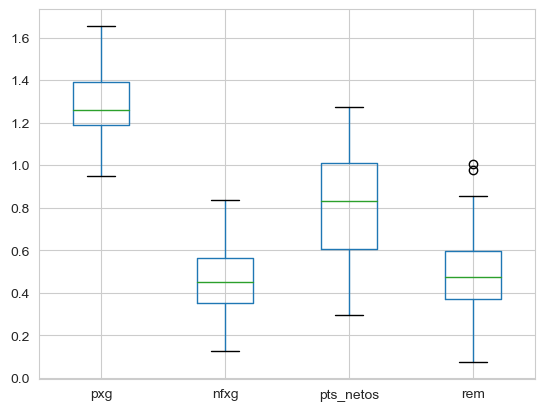

In [66]:
df_clean1.boxplot()
plt.show()

Hay 2 valores outliers en cuanto a los remates, los cuales no van a interferir en el trabajo 

## Preprocesamiento de datos 

In [67]:
#transformar a values el dataset para usarlo para ML
df_clean_val = df_clean.values

#nombre de los jugadores 
df_clean_index = df_clean.index

### Metodo del codo 

C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a m

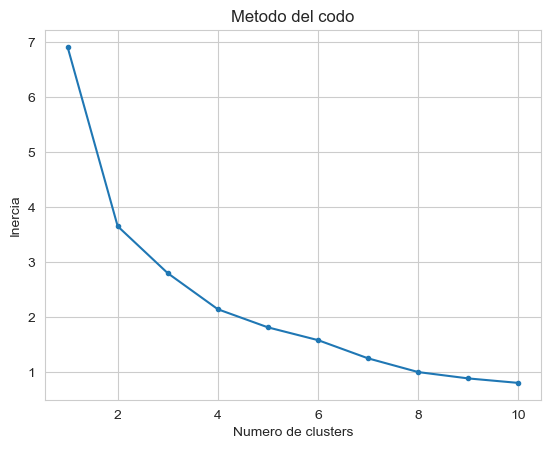

In [68]:
wcss = []
for i in range(1, 11):
    codo = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    codo.fit(df_clean_val)
    wcss.append(codo.inertia_)
plt.plot(range(1, 11), wcss, marker="o", ms=3)

plt.title('Metodo del codo')
plt.xlabel('Numero de clusters')
plt.ylabel('Inercia')
plt.show()

Se eligió el numero de cluster igual a 3 porque 2 era muy simple, y por el análisis previo del deporte. La diferencia del 3 al 4 es similar, por lo que no generaba ningun beneficio ir en contral del análisis y complejizar el modelo

### Instanciar modelo KMeans

In [69]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=6)
pred_y = model.fit_predict(df_clean)

C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### PCA y modelado

Porcentaje de varianza explicada por cada componente
[6.13227487e-01 2.89179297e-01 9.75932161e-02 2.68604567e-32]


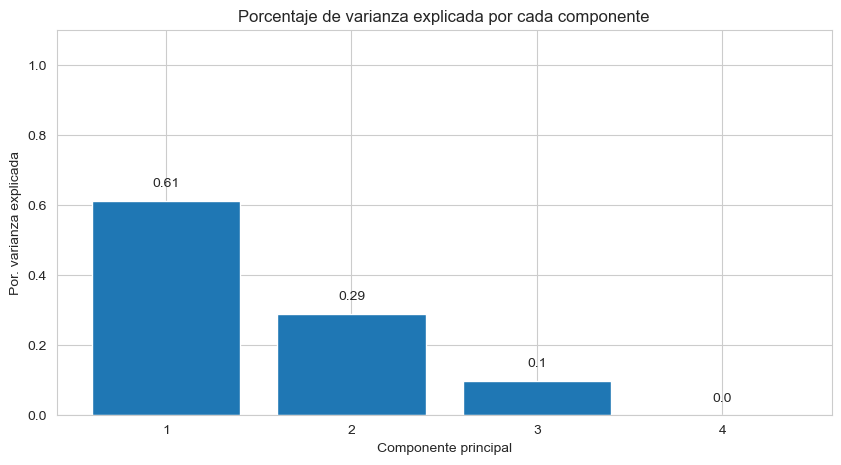

In [70]:
df_cluster =df_clean1
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_cluster)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

# Porcentaje de varianza explicada por cada componente
print('Porcentaje de varianza explicada por cada componente')
print(modelo_pca.explained_variance_ratio_)

import seaborn as sns;sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.bar(x= np.arange(modelo_pca.n_components_) + 1,height = modelo_pca.explained_variance_ratio_)
for x, y in zip(np.arange(len(df_cluster.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1);ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')
plt.show()

Sólo se utilizaron los 2 primeros componentes, que explicaban el 90% de la varianza

In [71]:
#Utilizar los 2 primeros componentes del PCA
df_pca = pd.DataFrame(data = modelo_pca.components_, columns=df_cluster.columns, 
             index = ["PC1","PC2","PC3","PC4"])

proyecciones = pca_pipe.transform(X=df_cluster)

proyecciones = pd.DataFrame(data = proyecciones,columns =  ["PC1","PC2","PC3","PC4"],
                           index = df_cluster.index)

proyecciones = proyecciones[["PC1", "PC2"]]

proyecciones.head(2)

,PC1,PC2
0,-2.432792,0.827065
1,-2.197807,1.238475


### Agregar numero de grupo de cada jugador en el df df_clean1 

In [72]:
#model con cluster utilizando el df proyecciones con el PCA
modelcc = model.fit(proyecciones)

#obtener labels del modelo fitteado
labels = modelcc.labels_

#agregar los labels al df
df_clean1['cluster_label'] = labels

#representamos puntos y centroides
# Obtener los Centroides
centroids = modelcc.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]


#cambiar el index por nombres de los jugadores
df_clean1.set_index(df_clean_index, inplace=True)
#print(cc1.sort_values("cluster_label"))
maskcc0 = (df_clean1['cluster_label'] == 0)
maskcc1 = (df_clean1['cluster_label'] == 1)
maskcc2 = (df_clean1['cluster_label'] == 2)




C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Listas de los nombres de los jugadores de cada grupo

In [73]:
print(df_clean1.head())

cluster0 = list(df_clean1[df_clean1["cluster_label"] == 0].index)
cluster1 = list(df_clean1[df_clean1["cluster_label"] == 1].index)
cluster2 = list(df_clean1[df_clean1["cluster_label"] == 2].index)


               pxg      nfxg  pts_netos       rem  cluster_label
name                                                            
Paquito   1.653968  0.465079   1.188889  0.649206              2
Stupa     1.617614  0.508333   1.109280  0.728220              2
Coello    1.568414  0.294758   1.273656  0.746640              2
Tapia     1.542876  0.352151   1.190726  0.630914              2
Lamperti  1.518056  0.258333   1.259722  0.676389              2


### Grafico de los grupos de los jugadores

C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_14252\2529816181.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.index, rotation=90)


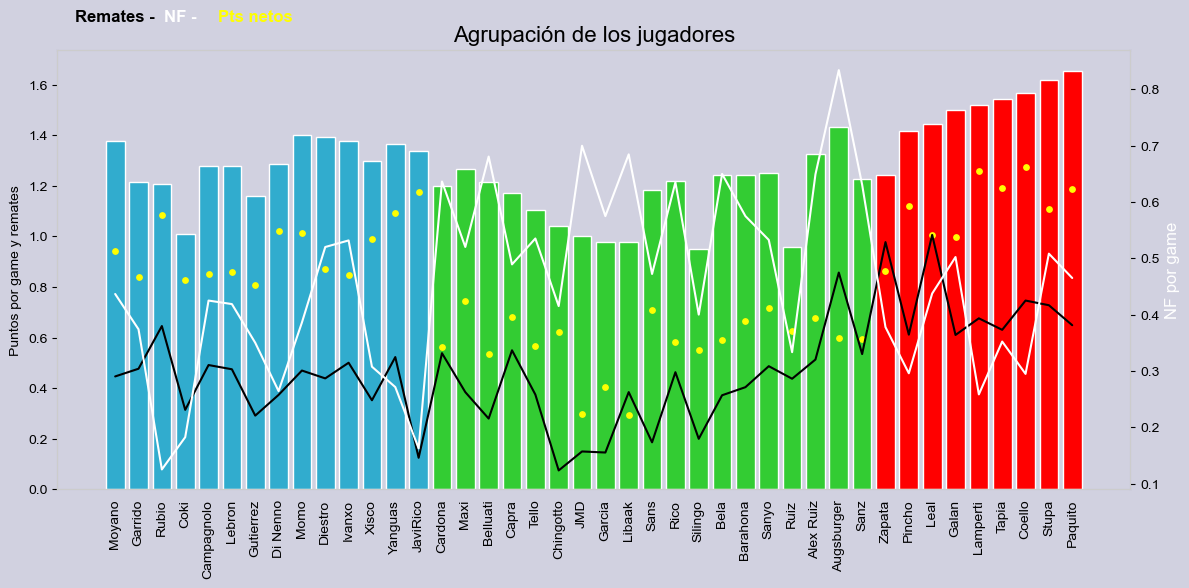

In [74]:
def g_bar(df):
    # Crea el gráfico scatter con nombres
    df= df.sort_values("cluster_label")
    
    fig, ax = plt.subplots(figsize=(12,6))
    fig.set_facecolor("#d1d1e0")
    name1 = "pts x game"
    name2 = "NF"
    name3 = "Rem"
    
    width = 0.2
    index = np.arange(3)
    
    
    celeste = "#31acce"
    verde_lindo= "#33cc33"
    
    #sns.barplot(x= df.index, y=df["rem"], hue=df["cluster_label"])
    # Define una paleta de colores personalizada
    colores = [celeste, verde_lindo, "red"]

    # Asigna colores a las barras en función de los valores de "cluster_label"
    colores_barras = [colores[label] for label in df["cluster_label"]]
    
    ax.patch.set_facecolor("#d1d1e0")
    ax.bar(df.index, df["pxg"], color=colores_barras)
    #ax.scatter(df.index, df["rem"], color ="black", s=15)
    ax.plot(df.index, df["rem"], color ="black")
    ax.scatter(df.index, df["pts_netos"], color ="yellow",s=15)
    #ax.plot(df.index, df["pts_netos"], color ="yellow")
    ax.set_xticklabels(df.index, rotation=90)
    ax.set_ylabel("Puntos por game y remates", color = "black")
    
    #compartir eje x 
    ax2 = ax.twinx()
    #ax2.scatter(df.index, df["nfxg"], color ="white",s=15) 
    ax2.plot(df.index, df["nfxg"], color ="white") 
   
    ax2.set_ylabel("NF por game", color = "white", fontsize=12)

    #cambiar colores
    ax.tick_params(axis="y", colors="black")
    ax2.tick_params(axis="y", colors="black")
    ax.tick_params(axis="x", colors="black")
   
    
    plt.title("Agrupación de los jugadores", color="black", fontsize=16)
    ax.xaxis.grid(False)  # Desactivar las líneas de la cuadrícula en el eje x
    ax.yaxis.grid(False)
    #ax.grid(False)
    ax2.grid(False)
    ax.text(0.1, 1.85, "Remates - ", color="black", weight='bold', ha='center',fontsize=12)
    ax.text(2.8, 1.85, "NF -", color="white", weight='bold', ha='center',fontsize=12)
    ax.text(6, 1.85, "Pts netos", color="yellow", weight='bold', ha='center', fontsize=12)
    
    
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
g_bar(df_clean1)

## Conclusiones de la agrupación
En el gráfico de arriba se observan los 3 grupos que agrupan a los jugadores según sus estadísticas por game que juegan; estadísticas que son un reflejo del rol del jugador o de su performance en los partidos analizados. Las barras indican el promedio de puntos que hacen, la línea blanca los errores no forzados y la línea negra los remates que realizan.

### Descripción de los grupos:
El grupo 1 y 2 tienen como similitud rematar menos y hacer menos puntos totales que el grupo 3.

#### Grupo 1, celeste, oportunistas 
Son jugadores que presentan valores de puntos y remates por game intermedios entre los 3 grupos. Suelen cometer pocos errores no forzados. Por estas 2 razones es que la cantidad de puntos netos es alta. En cuanto al rol en el partido, la mayoría son jugadores que arman el juego y que también definen los puntos; o que definen los puntos pero no rematan tanto como el grupo 3

#### Grupo 2, verde, defensivos 
Son jugadores que estadísticamente se diferencian por la alta cantidad de errores no forzados que cometen. La mayoría realiza pocos remates, aunque hay algunos jugadores que rematan frecuentemente. Suelen ser de los que menos puntos por game realizan por lo que tienen valores bajos de puntos netos. En cuanto a su rol en el partido suelen ser jugadores que arman el juego para que defina su compañero; o jugadores que no se encuentran en un alto nivel, hecho que se ve influido por la cantidad de partidos analizados y contra cuál pareja jugaron cuando se analizó.

#### Grupo 3, rojo, definidores 
Son los jugadores que realizan muchos puntos y remates junto con pocos o moderada cantidad de errores no forzados, por lo que suelen tener alta cantidad de puntos netos. Su rol en el partido es de definición del punto


### Evaluacion de Silhouette

In [75]:
from sklearn.metrics import silhouette_score, silhouette_samples
valor_x = df_clean1.drop("cluster_label", axis=1).values

valor_y = df_clean1.cluster_label.values

sc = StandardScaler()
valor_x_norm =sc.fit_transform(valor_x)
slc = {}

for k in range(2,6):
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=10).fit(valor_x_norm)
    clusters =kmeans.labels_
    slc[k] = silhouette_score(valor_x_norm, clusters)
    
slc



C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with

{2: 0.3514027452904437,
 3: 0.29520723165436374,
 4: 0.30956146618489244,
 5: 0.3160703788613919}

### Graficar silhouete 

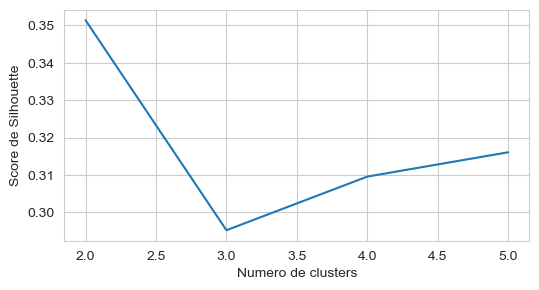

In [76]:
plt.figure(figsize=(6,3))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Numero de clusters")
plt.ylabel("Score de Silhouette")
plt.show()

La diferencia entre las opciones no es importante, y 2 era demasiado simple el modelo, no teniendo utilidad práctica 

# Análisis por equipos

In [77]:
#dataset con los datos por equipo con resultado - df_gop (gana o pierde)
df_gop = pd.read_excel("_ml1_eqxset.xlsx")

df_gop["pts_netos"] = df_gop["pto_tot"] - df_gop["nf"]

print(df_gop.columns)

print(f"Filas y columnas {df_gop.shape}")
df_gop.head(2)

Index(['nombre', 'nf', 'w', 'sm', 'ns', 'prec', 'csm', 'fondo', 'm3', 'm5',
       'm7', 'pto_tot', 'tot_snf', 'ed', 'spcsm', 'bloc', 'set', 'sk_prim',
       'games jug', 'sk_oro', 'resto_oro', 'op quiebre', 'circuito', 'torneo',
       'fase', 'gano_set', 'nfr', 'partido', 'pts_netos'],
      dtype='object')
Filas y columnas (196, 29)


,nombre,nf,w,sm,ns,prec,csm,fondo,m3,m5,...,sk_oro,resto_oro,op quiebre,circuito,torneo,fase,gano_set,nfr,partido,pts_netos
0,Tap-Coe,2,11,3,4,43,1,4,9,11,...,100.0,NaN,100.0,WPT,Vigo,Final,g,NaN,tcvsgc,27
1,Gal-Leb,10,16,6,1,86,3,0,4,1,...,NaN,0.0,0.0,WPT,Vigo,Final,p,NaN,tcvsgc,10


## Preprocesamiento del dataset

A partir del dataset de los equipos, los dividiremos en ganadores y perdedores. Se dividirán los valores por los games jugados asi el haber jugado mas games no sesga el estudio, y luego la variable categorica ganar (g) - perder(p)  se convertiran en variables numericas 1 y 0 respectivamente.

In [78]:
#cambiar index 
df_gop.set_index('nombre',inplace=True)

#Crear df con games ganados
df_gano = df_gop[df_gop["gano_set"]=="g"]
all_cols = ['nf', 'w', 'sm', 'ns', 'csm', 'fondo', 'm3', 'm5',
       'm7', 'pto_tot', 'tot_snf', 'ed','games jug', "set"]

#res_col = ["nf", "pto_tot", "tot_snf","sm","ns", "games jug"]
res_col = ["nf", "pto_tot", "pts_netos", "games jug"]


df_gano = df_gano[res_col]

df_ganoxgame = round(df_gano.div(df_gano["games jug"], axis=0),3)
df_ganoxgame["result"] ="g"


#df con games perdidos
df_perdio = df_gop[df_gop["gano_set"]=="p"]
df_perdio = df_perdio[res_col]

df_perdioxgame = round(df_perdio.div(df_perdio["games jug"], axis=0),3)
df_perdioxgame["result"] ="p"


#concatenar los df gana y pierde 
all = pd.concat([df_ganoxgame, df_perdioxgame])
all.drop("games jug", axis=1, inplace=True)
all["result"] = np.where(all["result"] == "g",1,0)
all

,nf,pto_tot,pts_netos,result
nombre,,,,
Tap-Coe,0.200,2.900,2.700,1
Tap-Coe,0.556,3.444,2.889,1
Tap-Coe,0.600,3.200,2.600,1
Momo-Sanyo,0.900,2.800,1.900,1
Tap-Coe,0.900,2.800,1.900,1
...,...,...,...,...
Tap-Coe,1.100,2.700,1.600,0
Maxi-Capra,0.750,2.625,1.875,0
Stupa-Di,1.200,2.600,1.400,0


### Graficar boxplots e identificar outliers

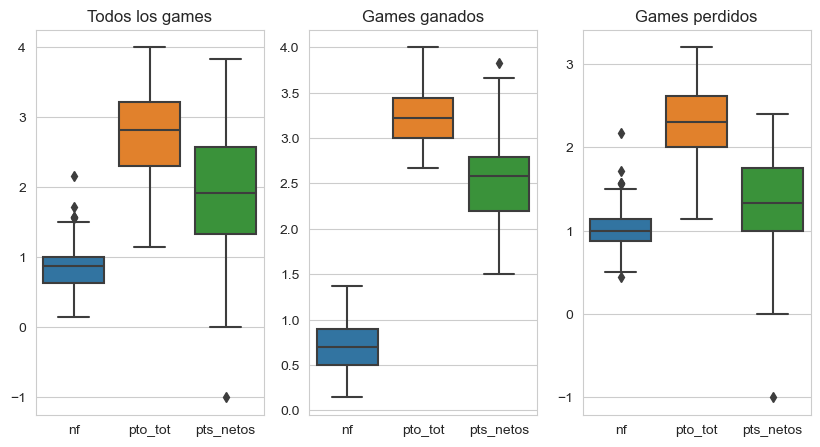


Identificar outliers
               nf  pto_tot  pts_netos  games jug result
nombre                                                 
Tello-Ruiz  2.167    1.167       -1.0        1.0      p
             nf  pto_tot  pts_netos  games jug result
nombre                                               
Stupa-Di  0.444    2.556      2.111        1.0      p


In [79]:
#all.boxplot()

boxdata1 =all[["nf", "pto_tot", "pts_netos"]]
boxdata2 =df_ganoxgame[["nf", "pto_tot", "pts_netos"]]
boxdata3 =df_perdioxgame[["nf", "pto_tot", "pts_netos"]]

fig, ax = plt.subplots(1,3, figsize=(10,5))
sns.boxplot(data=boxdata1, ax=ax[0])
ax[0].set_title("Todos los games")
sns.boxplot(data=boxdata2, ax=ax[1])
ax[1].set_title("Games ganados")
sns.boxplot(data=boxdata3, ax=ax[2])
ax[2].set_title("Games perdidos")
                            
plt.show()
#identificar outlier
print()
print("Identificar outliers")
print(df_perdioxgame[df_perdioxgame["pts_netos"] == df_perdioxgame["pts_netos"].min()])
print(df_perdioxgame[df_perdioxgame["nf"] == df_perdioxgame["nf"].min()])

### Procesamiento de los outliers

In [80]:
#Calculo para ver si es outlier el minimo en nf

# Calcular el primer cuartil (Q1)
q1 = np.quantile(df_perdioxgame["nf"], 0.25)

# Calcular el tercer cuartil (Q3)
q3 = np.quantile(df_perdioxgame["nf"], 0.75)

# Calcular la diferencia intercuartílica (IQR)
iqr = q3 - q1


# Calcular el límite inferior para valores atípicos
lower_bound = q1 - 1.5 * iqr

print("No forzados límite inferior para valores atípicos:", lower_bound)


No forzados límite inferior para valores atípicos: 0.473


In [81]:
#Calculo para ver si es outlier el maximo en tot_snf
# Calcular el primer cuartil (Q1)
qq1 = np.quantile(df_perdioxgame["pts_netos"], 0.25)

# Calcular el tercer cuartil (Q3)
qq3 = np.quantile(df_perdioxgame["pts_netos"], 0.75)

# Calcular la diferencia intercuartílica (IQR)
iqr2 = qq3 - qq1

# Calcular el límite inferior para valores atípicos
super_bound_snf = qq1 - 1.5 * iqr2

print("Puntos netos límite inferior para valores atípicos:", super_bound_snf)

Puntos netos límite inferior para valores atípicos: -0.125


In [82]:
mask1 = (all["nf"] == 0.444) & (all["pto_tot"] == 2.556) & (all["result"] == 0)
mask2 = (all["pts_netos"] < super_bound_snf) & (all["result"] == 0)
print(all.shape)
all = all[~(mask1 | mask2)]
print(all.shape)

(166, 4)
(164, 4)


Se eliminan los 2 outliers. En uno de ellos, el game fue muy parejo, en el cual la pareja que perdió hizo pocos errores no forzados en un game. Y en el otro los puntos netos le dieron negativo porque hicieron pocos puntos y muchos errorez no forzados

### Correlación

In [83]:
df_corr = all.corr()
df_corr.drop(["nf","pto_tot","pts_netos"], axis=1).T

,nf,pto_tot,pts_netos,result
result,-0.536903,0.784272,0.775189,1.0


### Análisis bivariado

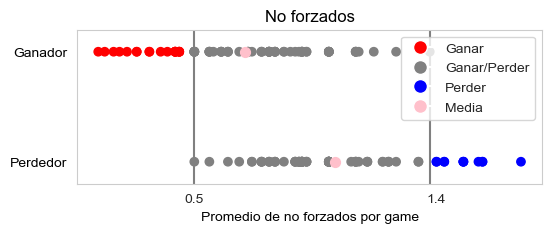

In [84]:
#errores no forzados
lim_min = all[all["result"] == 0]["nf"].min()
lim_max = all[all["result"] == 1]["nf"].max()
colors = all["nf"].apply(lambda x: 'grey' if lim_min <= x <= lim_max else 'blue' if x > lim_max else 'red')

plt.figure(figsize=(6, 2))
plt.scatter(all["nf"], all["result"], color=colors)
plt.title("No forzados", color="black")
plt.yticks([0,1],["Perdedor","Ganador"], color="black")
plt.xticks([round(lim_min,1),round(lim_max,1)])
plt.xlabel("Promedio de no forzados por game", color="black")
plt.margins(y=0.2)  # Ajusta el margen vertical

legend_labels = ['Ganar', 'Ganar/Perder', 'Perder', "Media"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red', 'grey', 'blue',"pink"]]


plt.axvline(x= lim_min, color= "grey")
plt.axvline(x= lim_max, color= "grey")
mean_nfp = all[all["result"] == 0]["nf"].mean()
mean_nfg = all[all["result"] == 1]["nf"].mean()

plt.scatter(mean_nfp, 0, color='pink', s=50, label='Media', zorder=3)
plt.scatter(mean_nfg, 1, color='pink', s=50, label='Media', zorder=3)
plt.grid(False)
plt.legend(legend_handles, legend_labels, loc='upper right')
plt.show()

Pareja que promedie menos de 0.5 errores no forzados por game, gana el partido el 100% de las veces. Media 0.69

Pareja que promedie más de 1.4 errores no forzados por game, pierde el partido el 100% de las veces. Media 1.02


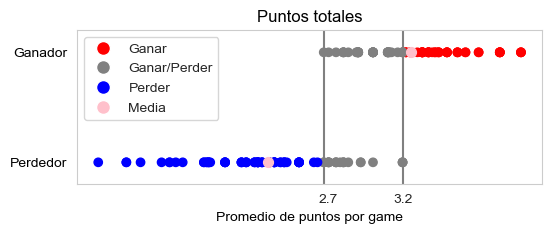

In [85]:
#Puntos totales 
lim_minpto = all[all["result"] == 1]["pto_tot"].min()
lim_maxpto = all[all["result"] == 0]["pto_tot"].max()
colors = all["pto_tot"].apply(lambda x: 'grey' if lim_minpto <= x <= lim_maxpto else 'red' if x > lim_maxpto else 'blue')

plt.figure(figsize=(6, 2))
plt.scatter(all["pto_tot"], all["result"], color=colors)
plt.title("Puntos totales", color="black")
plt.yticks([0,1],["Perdedor","Ganador"], color="black")
plt.xticks([round(lim_minpto,1),lim_maxpto])
plt.xlabel("Promedio de puntos por game", color="black")
plt.margins(y=0.2)  # Ajusta el margen vertical

legend_labels = ['Ganar', 'Ganar/Perder', 'Perder', "Media"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red', 'grey', 'blue',"pink"]]
plt.legend(legend_handles, legend_labels, loc='upper left')
plt.axvline(x= lim_minpto, color= "grey")
plt.axvline(x= lim_maxpto, color= "grey")
mean_pp = all[all["result"] == 0]["pto_tot"].mean()
mean_pg = all[all["result"] == 1]["pto_tot"].mean()

plt.scatter(mean_pp, 0, color='pink', s=50, label='Media', zorder=3)
plt.scatter(mean_pg, 1, color='pink', s=50, label='Media', zorder=3)
plt.grid(False)
plt.show()

Pareja que promedie más de 3.2 puntos por game, gana el partido el 100% de las veces. Media 3.25 

Pareja que promedie menos de 2.7 puntos por game pierde el 100%  de las veces. Media 2.29


1.2715308641975307 2.56878313253012


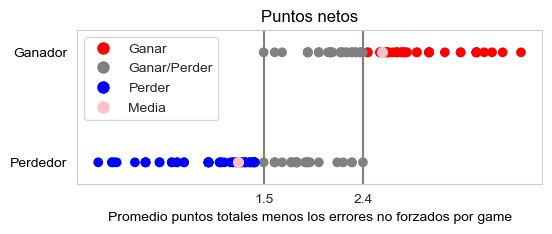

In [86]:
#Puntos netos, que seria los puntos totales menos los erroes no forzados que cometio 

#cantidad minima de puntos sin no forzados para ganar
lim_minsnf = all[all["result"] == 1]["pts_netos"].min()

#cantidad maxima de puntos sin no forzados rivales cuando se pierde
lim_maxsnf = all[all["result"] == 0]["pts_netos"].max()
colors = all["pts_netos"].apply(lambda x: 'grey' if lim_minsnf <= x <= lim_maxsnf else 'red' if x > lim_maxsnf else 'blue')

plt.figure(figsize=(6, 2))
plt.scatter(all["pts_netos"], all["result"], color=colors)
plt.title("Puntos netos", color="black")
plt.yticks([0,1],["Perdedor","Ganador"], color="black")
plt.xticks([lim_minsnf,lim_maxsnf])
plt.xlabel("Promedio puntos totales menos los errores no forzados por game", color="black")
plt.margins(y=0.2)  # Ajusta el margen vertical

legend_labels = ['Ganar', 'Ganar/Perder', 'Perder',"Media"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red', 'grey', 'blue',"pink"]]
plt.legend(legend_handles, legend_labels, loc='upper left')
plt.axvline(x= lim_minsnf, color= "grey")
plt.axvline(x= lim_maxsnf, color= "grey")
mean_pnp = all[all["result"] == 0]["pts_netos"].mean()
mean_png = all[all["result"] == 1]["pts_netos"].mean()
print(mean_pnp, mean_png)
plt.scatter(mean_pnp, 0, color='pink', s=50, label='Media', zorder=3)
plt.scatter(mean_png, 1, color='pink', s=50, label='Media', zorder=3)
plt.grid(False)
plt.show()

Pareja que promedie más de 2.4 puntos netos por game, gana el partido el 100% de las veces. Media 2.56 

Pareja que promedie menos de 1.5 puntos netos por game pierde el 100%  de las veces. Media 1.27


Un dato importante es que los puntos hechos por los jugadores tienen en cuenta los errores no forzados del rival, por lo que, un equipo que cometa muchos errores no forzados, hará que el otro equipo, sin hacer gran cantidad de puntos por mérito propio, tenga un promedio alto de puntos totales y puntos netos. Es la alta cantidad de errores no forzados lo que complica juntar a dos jugadores con muchos puntos que suelan hacer muchos errores no forzados.

Estos datos podrian ser tenidos en cuenta a la hora de armar las parejas, para el entrenamiento y para analizar la performance y claves del partido, de manera muy superficial

### Separar los jugadores segun su posición en la cancha, izquierda o derecha

In [87]:
#jug izq
df_izq = df_data[df_data["pos"]== "izq"]

#jug der
df_der = df_data[df_data["pos"]== "der"]

lista_col = ["nombre","pts_ganados","NF_total","pts_netos","games_jug"]

izq_g = df_izq.groupby(["nombre"])[lista_col].mean()
der_g = df_der.groupby(["nombre"])[lista_col].mean()

for col in der_g.columns:
    izq_g[col] = izq_g[col]/izq_g["games_jug"]
    der_g[col] = der_g[col]/der_g["games_jug"]

nombres_izq = df_izq["nombre"].unique()
nombres_der = df_der["nombre"].unique()

print(nombres_izq)
nombres_der



['Bela' 'Galan' 'Ivanxo' 'Tapia' 'Moyano' 'Lamperti' 'Gutierrez'
 'Augsburger' 'Maxi' 'Stupa' 'Pincho' 'Silingo' 'Zapata' 'Momo' 'Garrido'
 'Ruiz' 'Paquito' 'Tello' 'Leal' 'Coki' 'Garcia']


array(['Sanyo', 'Lebron', 'Cardona', 'Coello', 'Xisco', 'Belluati',
       'Capra', 'Libaak', 'Campagnolo', 'Di Nenno', 'Diestro', 'JMD',
       'Sans', 'Yanguas', 'Rico', 'Chingotto', 'Rubio', 'Alex Ruiz',
       'Sanz', 'JaviRico', 'Barahona'], dtype=object)

### Crear nuevo dataframe con la combinacion de todos los jugadores según por posición (izquierda-derecha)

In [88]:
df_newpar =pd.DataFrame()

for par_izq in nombres_izq:
    i = 1
    for par_der in nombres_der:
        df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
        i +=1

df_newpar.T
    

C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_14252\1255947752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_14252\1255947752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_14252\1255947752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_14252\1255947752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_14252\1255947752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_newpar[f"{par_izq}-{par_der}"]= izq_g.loc[par_izq] + der_g.loc[par_der]
C:\Users\UsuarioW10\AppData\Local\Temp\ipykernel_14252\1255947752.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

,pts_ganados,NF_total,pts_netos,games_jug
Bela-Sanyo,2.504826,1.164093,1.340734,2.0
Bela-Lebron,2.519461,1.068007,1.451454,2.0
Bela-Cardona,2.441176,1.245798,1.195378,2.0
Bela-Coello,2.810606,0.940837,1.869769,2.0
Bela-Xisco,2.529570,0.954685,1.574885,2.0
...,...,...,...,...
Garcia-Rubio,2.202381,0.721429,1.480952,2.0
Garcia-Alex Ruiz,2.288447,1.194379,1.094067,2.0
Garcia-Sanz,2.231451,1.210963,1.020487,2.0
Garcia-JaviRico,2.246499,0.747899,1.498599,2.0


In [89]:
#Nuevo dataframe con todas las combinaciones de jugadores, segun su posicion, posibles
df_newpar =df_newpar.T

print(f"Filas y columnas {df_newpar.shape}")
df_newpar.head(2)


Filas y columnas (441, 4)


,pts_ganados,NF_total,pts_netos,games_jug
Bela-Sanyo,2.504826,1.164093,1.340734,2.0
Bela-Lebron,2.519461,1.068007,1.451454,2.0


# Machine learning

### Entrenar el modelo

In [90]:
def entrenar(df_):
    xx = df_[df_.columns[:-1]].values
    yy = df_[df_.columns[-1]].values
    
    return xx, yy
xx, yy = entrenar(all)

x_train, x_test, y_train, y_test = train_test_split(xx,yy, test_size=0.2, random_state=45, stratify=yy)


### Elección del modelo

In [91]:
#elegir modelo, calibramos al svm y decisiontree que son los que necesitan de calibracion par aprobabilidades

lg = LogisticRegression()
svm_model = SVC(kernel='linear', probability=True) #support vector machine
svm_cal = CalibratedClassifierCV(svm_model)
nb = GaussianNB() #naibes
dt = DecisionTreeClassifier(max_depth=3, random_state=1, criterion ="gini")
dt_cal =  CalibratedClassifierCV(dt)
#bag_class= BaggingClassifier(base_estimator=knn, n_estimators=300, n_jobs=-1)
#no se utilizó porque no superó al logistic regression y hacia mas lento el programa


#Se realiza la eleccion de un modelo junto con su métrica, el que tenga el valor mas alto pasa a ser el mejor_modelo
mejor_modelo = None
mejor_puntaje = 0
dicc_prec = {}
list_model = {"Logistic regression":lg, "svm":svm_cal, "Naives bayes":nb,"Decision Tree":dt_cal} #, "bagging":bag_class

for key, modelo in list_model.items():
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    #obtenemos el puntaje
    puntaje = accuracy_score(y_test, y_pred)
    dicc_prec[key] = puntaje
    
    if puntaje > mejor_puntaje:
        mejor_puntaje = puntaje
        mejor_modelo = modelo
        
#gridsearch
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'penalty': ['l1', 'l2'],  # Tipo de regularización (L1 o L2)
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']  # Algoritmo de optimización
}

grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train,y_train)
print(f"""
Mejores parametros: {grid_search.best_params_}
"Mejor CV score: {grid_search.best_score_}
Accuracy del modelo: {round(accuracy_score(y_test, grid_search.predict(x_test)),2)}
""")

        
#tenemos el modelo con el mejor accuracy_Score, que es la variable: mejor_modelo, asi que ahora se entrena
mejor_modelo.fit(x_train, y_train)
y_pred2 = mejor_modelo.predict(x_test)
y_predict = mejor_modelo.predict_proba(x_test).round(3)

print(dicc_prec)

C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: Con


Mejores parametros: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
"Mejor CV score: 0.915954415954416
Accuracy del modelo: 0.94

{'Logistic regression': 0.9393939393939394, 'svm': 0.9090909090909091, 'Naives bayes': 0.9090909090909091, 'Decision Tree': 0.9090909090909091}


C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3

In [92]:
print("El modelo con el mayor puntaje es:", mejor_modelo, round(mejor_puntaje,2))

El modelo con el mayor puntaje es: LogisticRegression() 0.94


### Métricas

In [93]:
print(classification_report(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.94      0.94      0.94        17

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33

0.9393939393939394


La métrica fue accuracy debido a que el valor del modelo es por error y no por el tipo de error, ya que en este deporte equivocarse no trae consecuencias distintas según se haya predicho triunfo o derrota. Asi que, se utilizó el promedio de la precision y recall

### Cross validation

In [94]:
from sklearn.model_selection import cross_val_score


mse_cv = cross_val_score(mejor_modelo, x_train, y_train,cv=10, scoring='accuracy') # 'accuracy', 'precision', 'recall', 'f1', 
#print(mse_cv)
print(f"El resultado fue {mse_cv.mean()}, similar al score_accuracy ")

El resultado fue 0.9230769230769231, similar al score_accuracy 


### Predecir con los nuevos datos de todas las parejas posibles

In [95]:
#probar con nuevo df
print(all.head(2))
df_newpar = df_newpar[["NF_total", "pts_ganados","pts_netos"]]
df_newpar.head(2)
val_df_newpar = df_newpar.values
print(val_df_newpar)

            nf  pto_tot  pts_netos  result
nombre                                    
Tap-Coe  0.200    2.900      2.700       1
Tap-Coe  0.556    3.444      2.889       1
[[1.16409266 2.50482625 1.34073359]
 [1.06800684 2.51946108 1.45145423]
 [1.24579832 2.44117647 1.19537815]
 ...
 [1.21096346 2.23145072 1.02048726]
 [0.74789916 2.2464986  1.49859944]
 [1.14285714 2.19047619 1.04761905]]


In [96]:
y = mejor_modelo.predict_proba(val_df_newpar).round(3)

#porcentaje de victoria del set
prob_predict = y[:,1]

#crear nuevo dataset y luego agregarle columna con probabilidades
df_predict = df_newpar

df_predict["probabilidad"] = prob_predict

print(f"Filas y columnas {df_predict.shape}")
#df_predict.drop("games_jug", axis=1, inplace=True)
df_predict.head()

Filas y columnas (441, 4)


,NF_total,pts_ganados,pts_netos,probabilidad
Bela-Sanyo,1.164093,2.504826,1.340734,0.093
Bela-Lebron,1.068007,2.519461,1.451454,0.125
Bela-Cardona,1.245798,2.441176,1.195378,0.058
Bela-Coello,0.940837,2.810606,1.869769,0.438
Bela-Xisco,0.954685,2.529570,1.574885,0.169


### Crear funcion para agregar el grupo de cada jugador al df

In [97]:
#fx para sumar otro cluster mayor_prob43
def clus(msj):
    pat1 = r"(\w+)-\w+"
    #pat2= r"\w+-(\w+)"
    #pat2 = r"\w+-(\w+)?( \w+)?"
    pat2= r"\w+-(\w+.*)"
    jug1 = re.findall(pat1, msj)
    jug2 = re.findall(pat2, msj)
    
    
    if jug1[0] in cluster0:
        c1= "1"
    elif jug1[0] in cluster1:
        c1="2"
    elif jug1[0] in cluster2:
        c1="3"
    
    #else:
        #c1="3"
        
    if jug2[0] in cluster0:
        c2= "1"
    elif jug2[0] in cluster1:
        c2="2"
    elif jug2[0] in cluster2: 
        c2="3"
    
    return f"{c1} - {c2}"

## Análisis de las top 5 parejas del ranking

In [98]:
#parejas top5
def buscar_top(name):
    x = df_predict.loc[name]
    return x

top1= buscar_top("Tapia-Coello")

top2 = buscar_top("Galan-Lebron")
top3 = buscar_top("Stupa-Di Nenno")
top4 = buscar_top("Momo-Sanyo")
top5 = buscar_top("Paquito-Chingotto")
                  
tops5 = df_predict.loc[["Tapia-Coello", "Galan-Lebron", "Stupa-Di Nenno","Momo-Sanyo","Paquito-Chingotto"]]

#ops5 = tops5.rename({"NF_total":"No forzados"}, axis="column")
tops5.columns = ["no forzados", "pts_totales", "pts_netos","probabilidad"]

tops5 = tops5[["pts_totales","pts_netos", "no forzados", "probabilidad"]]

tops5["ranking"]= 1,2,3,4,5
tops5["grupo"] = tops5.index.to_series().apply(clus)
tops5

,pts_totales,pts_netos,no forzados,probabilidad,ranking,grupo
Tapia-Coello,3.095960,2.442761,0.653199,0.865,1,3 - 3
Galan-Lebron,2.791439,1.871784,0.919655,0.430,2,3 - 1
Stupa-Di Nenno,2.855037,2.066339,0.788698,0.591,3,3 - 1
Momo-Sanyo,2.686124,1.790843,0.895281,0.330,4,1 - 2
Paquito-Chingotto,2.658249,1.781066,0.877183,0.313,5,3 - 2


## Análisis del ranking según su agrupacion y estilo de juego
### Parejas segun ranking:

#### Numero 1: 
Tuvo un comienzo de año histórico, solo perdiendo un partido, por lo que la diferencia en la probabilidad con el resto es lógica. Es la única pareja que juega con dos jugadores que tienen el mismo estilo de juego, situación que es difícil de lograr ya que “compiten” por hacer el mismo punto. Además de hacer tantos puntos ambos, su otra virtud es los pocos errores no forzados que cometen los 2, lo cual suele ser una debilidad cuando se juntan dos jugadores que son definidores

#### Numero 2 y 3: 
Tienen el mismo estilo de juego 3-1, siendo los jugadores de izquierda definidores y los dos jugadores de derecha del grupo 1, oportunistas, que suelen armar el juego y definirlo cuando tienen la oportunidad. Siendo uno, Lebron, de los mejores jugadores del circuito, y el otro, Di Nenno, de los mejores defensores


#### Numero 4: 
Tiene un jugador del grupo uno, Momo con las típicas características de los oportunistas, y el otro jugador, Sanyo, que es penalizado por la cantidad de errores no forzados, siendo su estilo de juego tanto del 1 como del 3, pero promediando estar en el 2 por los errores no forzados

#### Numero 5: 
Tiene un estilo distinto a las demás, teniendo un jugador de izquierda, Paquito, netamente definidor, y un compañero que es de los mejores defensores y armadores de juego, sirviéndole el punto a su compañero. Luego de un mal comienzo mejoraron notoriamente, escalando posiciones en el ranking.

##### Esto denota que no hay una formula única en el armado de parejas con respecto a los roles de cada jugador

#### Se estableció como límite tener una probabilidad de ganar el set mayor o igual que a 0.430 (43%), ya que es el peor ranking de las top 3, que son las únicas parejas consolidadas, las demás alternan buenos y malos torneos.

In [99]:
#mayor prob que 3ero ranking
mask_pred43 = df_predict["probabilidad"] >= 0.43

mayor_prob43 = df_predict[mask_pred43].sort_values("probabilidad",ascending=False)
print(mayor_prob43.shape)
mayor_prob43

(97, 4)


,NF_total,pts_ganados,pts_netos,probabilidad
Lamperti-Coello,0.572173,3.092864,2.520691,0.887
Paquito-Coello,0.764272,3.184202,2.419930,0.877
Tapia-Coello,0.653199,3.095960,2.442761,0.865
Stupa-Coello,0.816407,3.147830,2.331422,0.840
Pincho-Coello,0.594590,2.984335,2.389745,0.816
...,...,...,...,...
Paquito-Sanz,1.105827,2.902665,1.796838,0.434
Stupa-Alex Ruiz,1.141378,2.923289,1.781911,0.434
Moyano-Xisco,0.774194,2.709677,1.935484,0.433
Paquito-Barahona,1.037721,2.861691,1.823970,0.432


### Agregar el grupo de cada jugador al df de las parejas

In [100]:
mayor_prob43["grupo"] = mayor_prob43.index.to_series().apply(clus)

mayor_prob43.head(20)
    


,NF_total,pts_ganados,pts_netos,probabilidad,grupo
Lamperti-Coello,0.572173,3.092864,2.520691,0.887,3 - 3
Paquito-Coello,0.764272,3.184202,2.419930,0.877,3 - 3
Tapia-Coello,0.653199,3.095960,2.442761,0.865,3 - 3
Stupa-Coello,0.816407,3.147830,2.331422,0.840,3 - 3
Pincho-Coello,0.594590,2.984335,2.389745,0.816,3 - 3
Galan-Coello,0.792485,3.082584,2.290099,0.805,3 - 3
Momo-Coello,0.672026,2.991904,2.319878,0.789,1 - 3
Leal-Coello,0.716584,3.002467,2.285882,0.777,3 - 3
Lamperti-Yanguas,0.573044,2.900074,2.327030,0.761,3 - 1
Lamperti-JaviRico,0.450664,2.826376,2.375712,0.759,3 - 1


Observación:a nivel jugadores las 8 primeras parejas con mayor probabilidad de ganar tenían al jugador Coello como jugador derecho, lo que denota su gran temporada

In [101]:
#Jugadores que mas se repiten
pat1 = r"\w+-Coello"
coello_sum = 0
pat2 = r"Tapia-\w+"
tapia_sum=0
pat3 = r"Paquito-\w+"
paquito_sum=0
pat4= r"Galan-\w+"
gal_sum =0
pat5= r"Stupa-\w+"
stu_sum =0
pat6= r"Lamperti-\w+"
lam_sum = 0

for i in mayor_prob43.index:
    if re.match(pat1, i):
        coello_sum +=1
    if re.match(pat2,i):
        tapia_sum +=1
    if re.match(pat3,i):
        paquito_sum +=1
    if re.match(pat4,i):
        gal_sum +=1
    if re.match(pat5,i):
        stu_sum +=1
    if re.match(pat6,i):
        lam_sum +=1
        
print(f"""Jugadores que mas se repiten:
Coello: {coello_sum},Paquito: {paquito_sum},Lamperti: {lam_sum}, Tapia: {tapia_sum},Stupa: {stu_sum},Galan: {gal_sum}
""")

Jugadores que mas se repiten:
Coello: 17,Paquito: 14,Lamperti: 14, Tapia: 12,Stupa: 11,Galan: 8



### Graficar cantidad de estilos en el df de todas las parejas posibles

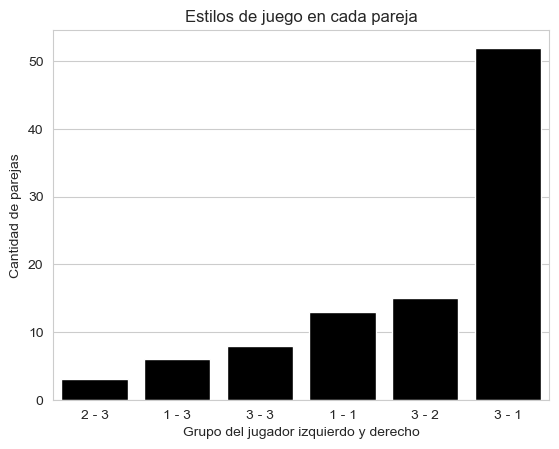

In [102]:
#sns.histplot(mayor_prob43["grupo"])
order = mayor_prob43['grupo'].value_counts(ascending=True).index

# Crea el gráfico de barras con las categorías ordenadas
sns.countplot(data=mayor_prob43, x="grupo", order=order, color="black")
plt.xlabel("Grupo del jugador izquierdo y derecho")
plt.ylabel("Cantidad de parejas")
plt.title("Estilos de juego en cada pareja")
#plt.xticks(rotation=45)  # Opcional: rota las etiquetas del eje x si es necesario
plt.show()

Las 6 primeras parejas tenían a jugadores 3-3, es decir, dos jugadores con estilo de juego de definición. Sin embargo, la mayoría de las parejas tienen una formación 3-1. Esto ocurre, que la mejor pareja probabilísticamente no sea la más frecuente, porque es complicado que 2 jugadores de un mismo equipo hagan gran cantidad de puntos, como para entrar en el grupo de los definidores, ya que “compiten” entre ellos por hacer el punto. También, hay más jugadores derechos que zurdos, siendo más complicado rematar desde la posición derecha si sos derecho. Otro punto a tener en cuenta es que cuando se juntan dos jugadores con estilo de definidores, al no tener la vocación defensiva y de armar el juego, como los del grupo 1 y 2, suelen cometer mas errores no forzados; que tenían una correlación negativa con el resultado de -0.53 

# Conclusiones

Encontramos mediante el análisis del deporte y la aplicación de la IA, que en el padel se pueden distinguir tres tipos de estilos de juegos: oportunista (grupo 1), defensivo (grupo 2), y definidor (grupo 3). De estas, la combinación mas frecuente es la 3-1, teniendo al jugador izquierdo como definidor  y al derecho como oportunista. La combinación más efectiva, estadísticamente hablando, es la 3-3, pero en la realidad es difícil de lograr que funcione esta combinación porque requiere que ambos jugadores hagan muchos puntos y remates, y pocos errores no forzados. Que es la combinación más efectiva está revalidado con los resultados que obtuvo la pareja 1 del ranking, logrando estar casi medio año invicta, solo perdiendo un partido. Sin embargo, se han juntado otros jugadores con estilo de juego de definidores y suelen quedarse los dos, o uno de los dos, clasificados como del grupo 2, por el alto nivel de errores no forzados y los pocos puntos totales y netos ya que “competían” entre ellos por los puntos de su equipo

Es importante aclarar que casi todas las combinaciones de estilos pueden ser efectivas para lograr una buena temporada a nivel elite, ya que, por ejemplo, en el top 5 quedaron representadas la mayoría de las combinaciones: tener a un definidor con otro definidor, oportunista o defensivo, y tener a un oportunista con un defensivo. La pareja con un estilo que no fue representada es la 2-2, que sería tener dos jugadores netamente defensivos, pero si hay una pareja dentro del top 10 que está clasificada como 2-2 pero es por el alto nivel de errores no forzados y los pocos puntos que hacen cada uno, ya que ambos tienen rol de definidores.

Acerca de la posibilidad de cambiar de parejas, teniendo en cuenta que casi todos los estilos de juego pueden tener éxito a nivel de elite, el poder cambiar de compañero varias veces en el año tiene su lado bueno y malo. Es beneficioso ya que con una probabilidad de ganar el set de 0.430(43%) esa pareja podría llegar a estar en el top 5, lo que le significaría ganar premios y mejores sponsors.  Sin embargo, pocas parejas han jugado a su mejor nivel, y lo han mantenido, en sus primeros partidos juntas, siendo el cambio un arma de doble filo para los jugadores. 
Quienes sí se benefician de los cambios son el deporte y el público. El deporte se va renovando constantemente, y se pueden ver uniones de jugadores de todo tipo, siempre es pos de mejorar. Esto, a su vez, renueva el desafío a los que estén mejor en el ranking, quienes tienen que ir mejorando también porque las parejas de abajo no dejarán de realizar cambios que los acerquen a ellos.



Limitaciones del estudio:
-	La cantidad de partidos analizados para cada pareja/jugador es diversa, habiendo parejas con 1 o 2 partidos, o que tuvieron un torneo muy bueno o muy malo, sobredimensionando o subestimando sus estadísticas
-	Contra qué pareja fueron los partidos analizados
-	Los distintos roles de los jugadores dentro de la pareja en donde no es lo mismo “competir” por hacer el punto con tu compañero que tener un compañero que tienda a armar el punto para que el otro defina.


In [103]:
# Registra la hora de finalización
end_time = time.time()

# Calcula la diferencia de tiempo en segundos
execution_time = end_time - start_time

execution_time

21.34900164604187